In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
# scikit-learn에서 보스턴 데이터셋이 삭제된 관계로, load_boston을 이용해 데이터셋을 불러올 수 없습니다.
# 그래서 데이터셋을 직접 불러온 뒤, 책에서 사용하는 데이터셋과 세팅이 같도록 csv 파일을 수정하였습니다.

df = pd.read_csv("https://github.com/selva86/datasets/raw/master/BostonHousing.csv")
df.rename(columns={'medv': 'target'}, inplace=True)
df.columns = df.columns.str.upper()
print(df.tail())

        CRIM   ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
501  0.06263  0.0  11.93     0  0.573  6.593  69.1  2.4786    1  273     21.0   
502  0.04527  0.0  11.93     0  0.573  6.120  76.7  2.2875    1  273     21.0   
503  0.06076  0.0  11.93     0  0.573  6.976  91.0  2.1675    1  273     21.0   
504  0.10959  0.0  11.93     0  0.573  6.794  89.3  2.3889    1  273     21.0   
505  0.04741  0.0  11.93     0  0.573  6.030  80.8  2.5050    1  273     21.0   

          B  LSTAT  TARGET  
501  391.99   9.67    22.4  
502  396.90   9.08    20.6  
503  396.90   5.64    23.9  
504  393.45   6.48    22.0  
505  396.90   7.88    11.9  


In [3]:
# 데이터 정규화
scaler = StandardScaler()
scaled = scaler.fit_transform(df.iloc[:, :-1].round(4)) # 입력값 정규화
scaled_df = pd.DataFrame(scaled, columns=df.columns[:-1])  # float64로 생성
df = pd.concat([scaled_df, df[['TARGET']].reset_index(drop=True)], axis=1) # 기존 target 열 붙이기
print(df.tail())

         CRIM        ZN     INDUS      CHAS       NOX        RM       AGE  \
501 -0.413232 -0.487722  0.115738 -0.272599  0.158124  0.439316  0.018673   
502 -0.415246 -0.487722  0.115738 -0.272599  0.158124 -0.234548  0.288933   
503 -0.413442 -0.487722  0.115738 -0.272599  0.158124  0.984960  0.797449   
504 -0.407763 -0.487722  0.115738 -0.272599  0.158124  0.725672  0.736996   
505 -0.415001 -0.487722  0.115738 -0.272599  0.158124 -0.362767  0.434732   

          DIS       RAD       TAX   PTRATIO         B     LSTAT  TARGET  
501 -0.625796 -0.982843 -0.803212  1.176466  0.387217 -0.418147    22.4  
502 -0.716639 -0.982843 -0.803212  1.176466  0.441052 -0.500850    20.6  
503 -0.773684 -0.982843 -0.803212  1.176466  0.441052 -0.983048    23.9  
504 -0.668437 -0.982843 -0.803212  1.176466  0.403225 -0.865302    22.0  
505 -0.613246 -0.982843 -0.803212  1.176466  0.441052 -0.669058    11.9  


In [4]:
# 데이터 준비
data = torch.from_numpy(df.values).float()

x = data[:, :-1] # 마지막 행을 제외한 행들을 x로 설정
y = data[:, -1:] # 마지막 행만 y로 설정

print(x.shape, y.shape)

# 학습 설정
epochs = 200000     # 학습 반복 횟수
lr = 1e-4           # 학습률
interval = 10000    # 학습 결과를 출력할 간격

torch.Size([506, 13]) torch.Size([506, 1])


In [8]:
# 모델 정의 (직접 정의)

class MyModel(nn.Module):

    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim                      # 입력 차원 저장
        self.output_dim = output_dim                    # 출력 차원 저장

        super().__init__()                              # nn.Module 초기화
        
        # 네트워크 층 정의
        self.linear1 = nn.Linear(input_dim, 3)          # 입력 -> 중간 차원 3
        self.linear2 = nn.Linear(3, 3)                  # 중간 차원 유지
        self.linear3 = nn.Linear(3, 3)                  # 중간 차원 유지
        self.linear4 = nn.Linear(3, output_dim)         # 중간 -> 출력 차원
        self.act = nn.ReLU()                            # 활성화 함수: ReLU
    
    # 순전파 정의: 선형 변환 + ReLU 활성화 반복
    def forward(self, x):
        h = self.act(self.linear1(x))
        h = self.act(self.linear2(h))
        h = self.act(self.linear3(h))
        y = self.linear4(h)                             # 마지막에는 활성화 없이 출력
        return y

model = MyModel(x.size(-1), y.size(-1))
print(model) # 모델 구조 출력

MyModel(
  (linear1): Linear(in_features=13, out_features=3, bias=True)
  (linear2): Linear(in_features=3, out_features=3, bias=True)
  (linear3): Linear(in_features=3, out_features=3, bias=True)
  (linear4): Linear(in_features=3, out_features=1, bias=True)
  (act): ReLU()
)


In [5]:
# 모델 정의 (nn.Sequential() 사용)

model = nn.Sequential(
    nn.Linear(x.size(-1), 3),
    nn.LeakyReLU(),
    nn.Linear(3, 3),
    nn.LeakyReLU(),
    nn.Linear(3, 3),
    nn.LeakyReLU(),
    nn.Linear(3, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y.size(-1)),
)

print(model) # 모델 구조 출력

Sequential(
  (0): Linear(in_features=13, out_features=3, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=3, out_features=3, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=3, out_features=3, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=3, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)


In [6]:
optimizer = optim.SGD(model.parameters(), lr=lr) # 옵티마이저 함수로 확률적 경사 하강법 사용

# 모델 학습
for i in range(epochs):
    y_hat = model(x)                # 예측값 계산
    loss = F.mse_loss(y_hat, y)     # MSE 손실 함수 계산

    optimizer.zero_grad()           # 기울기 초기화
    loss.backward()                 # 역전파로 기울기 계산
    optimizer.step()                # 가중치 업데이트

    # 학습 진행 상황 출력
    if (i + 1) % interval == 0:
        print('Epoch %d: loss=%.4e' % (i + 1, loss))

Epoch 10000: loss=1.2171e+01
Epoch 20000: loss=1.1924e+01
Epoch 30000: loss=1.1859e+01
Epoch 40000: loss=1.1233e+01
Epoch 50000: loss=1.1222e+01
Epoch 60000: loss=1.1219e+01
Epoch 70000: loss=1.1217e+01
Epoch 80000: loss=1.1215e+01
Epoch 90000: loss=1.1213e+01
Epoch 100000: loss=1.1211e+01
Epoch 110000: loss=1.1208e+01
Epoch 120000: loss=1.1206e+01
Epoch 130000: loss=1.1204e+01
Epoch 140000: loss=1.1201e+01
Epoch 150000: loss=1.1199e+01
Epoch 160000: loss=1.1196e+01
Epoch 170000: loss=1.1194e+01
Epoch 180000: loss=1.1192e+01
Epoch 190000: loss=1.1189e+01
Epoch 200000: loss=1.1187e+01


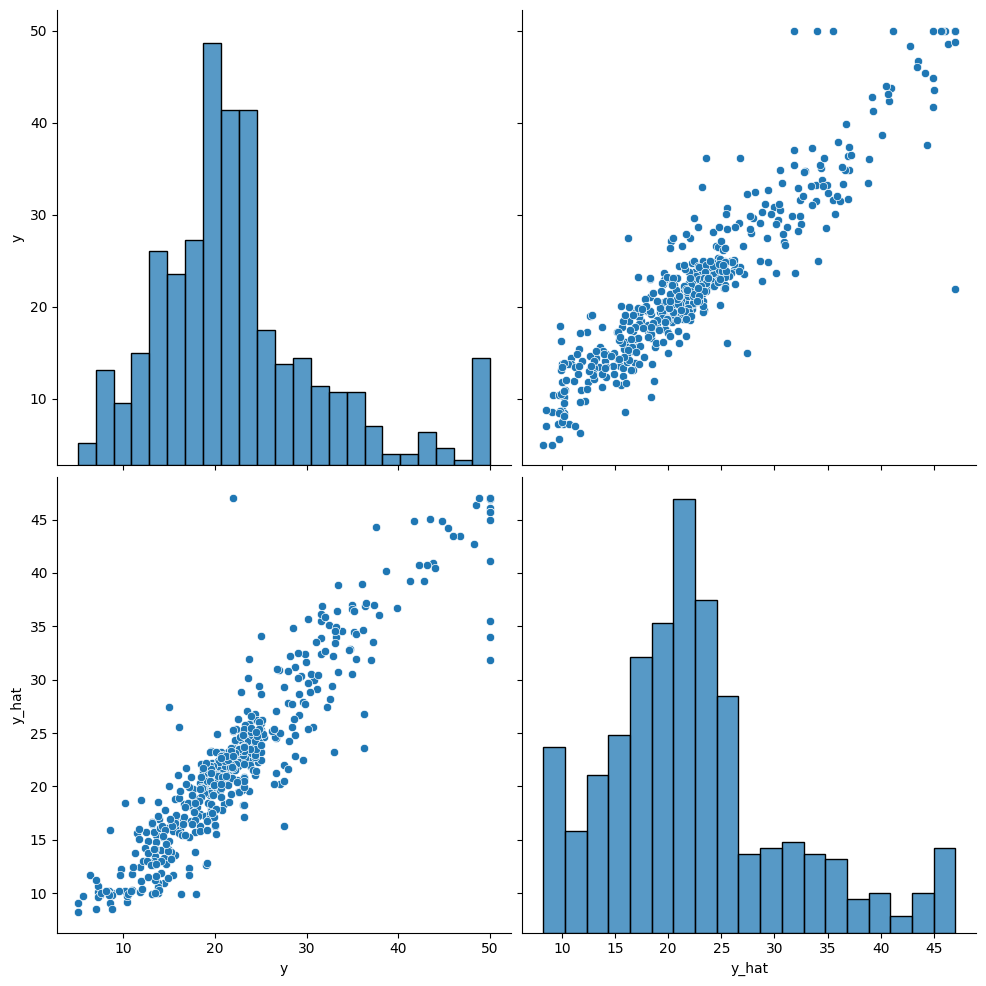

In [7]:
# 결과 시각화

df = pd.DataFrame(torch.cat([y, y_hat], dim=1).detach().numpy(), columns=["y", "y_hat"])

sns.pairplot(df, height=5)
plt.show()